In [54]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from pathlib import Path


In [55]:
# import nba data set
PROJECT_DIR = Path.cwd()
DATA_DIR = PROJECT_DIR / 'nba_py_data'
filename = 'prepared-data-17-18.csv'

nba_data = pd.read_csv(DATA_DIR / filename,index_col='game_id')

In [56]:
# fill na's with average minus in that column (bad I know but I just want this to run)
for i in nba_data.columns:
    adj = 2
    if i.find('ORTG') > 0:
        nba_data[i].fillna((nba_data[i].mean()-adj), inplace=True)
    if i.find('DRTG') > 0:
        nba_data[i].fillna((nba_data[i].mean()+adj), inplace=True)

In [57]:
nba_data_shuffle = nba_data.sample(frac=1)
nba_train_data = nba_data_shuffle[:1100]
nba_train_labels = nba_train_data['pt_dif']
nba_test_data = nba_data_shuffle[1100:]
nba_test_labels = nba_test_data['pt_dif']

nba_train_data.drop(columns='pt_dif',inplace=True)
nba_test_data.drop(columns='pt_dif',inplace=True)

/Users/William/PAUL/paul/.venv/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [58]:
train_data = nba_train_data.values
train_labels = nba_train_labels.values
test_data = nba_test_data.values
test_labels = nba_test_labels.values

In [59]:
def build_model():
  model = keras.Sequential([
    keras.layers.Dense(64, activation=tf.nn.relu,
                       input_shape=(train_data.shape[1],)),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(1)
  ])

  optimizer = tf.train.RMSPropOptimizer(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
  return model

model = build_model()
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 64)                1856      
_________________________________________________________________
dense_22 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 65        
Total params: 6,081
Trainable params: 6,081
Non-trainable params: 0
_________________________________________________________________


In [60]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 500

# Store training stats
history = model.fit(train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

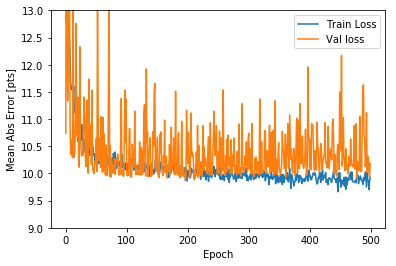

In [62]:

def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [pts]')
  plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
           label='Train Loss')
  plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
  plt.legend()
  plt.ylim([9, 13])

plot_history(history)


.................................................

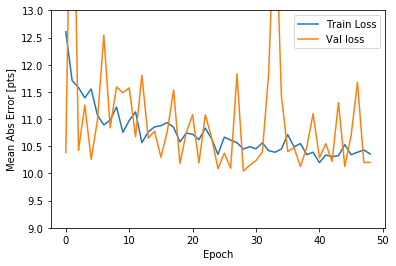

In [63]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])

plot_history(history)


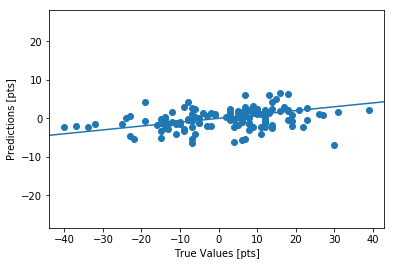

In [69]:
test_predictions = model.predict(test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [pts]')
plt.ylabel('Predictions [pts]')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-50, 50], [-5, 5])


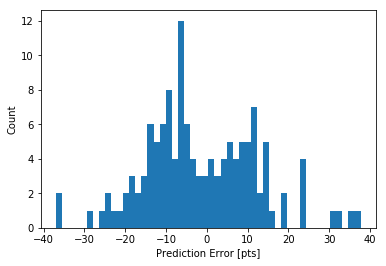

In [66]:
error = test_predictions - test_labels
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error [pts]")
_ = plt.ylabel("Count")

In [74]:
n_correct = 0
for i in range(len(test_predictions)):
    if (test_predictions[i] > 0) == (test_labels[i] > 0):
        n_correct += 1

print(n_correct,i)
print(n_correct/i)
    

82 129
0.6356589147286822
